In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_dir = 'dataset FER/train'
test_dir = 'dataset FER/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes


Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

model.summary()


2025-07-21 13:33:11.485187: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
checkpoint = ModelCheckpoint('best_fer_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, lr_reduce, checkpoint]
)

model.save("FER2.0_model.h5")

Epoch 1/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.2619 - loss: 1.7665

/home/revanth1206/Revanth/pyml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


707/707 ━━━━━━━━━━━━━━━━━━━━ 452s 639ms/step - accuracy: 0.2619 - loss: 1.7664 - val_accuracy: 0.3346 - val_loss: 1.6314 - learning_rate: 0.0010
Epoch 2/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.3269 - loss: 1.6665

707/707 ━━━━━━━━━━━━━━━━━━━━ 448s 633ms/step - accuracy: 0.3269 - loss: 1.6665 - val_accuracy: 0.3819 - val_loss: 1.6137 - learning_rate: 0.0010
Epoch 3/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.3429 - loss: 1.6460

707/707 ━━━━━━━━━━━━━━━━━━━━ 448s 633ms/step - accuracy: 0.3429 - loss: 1.6460 - val_accuracy: 0.3951 - val_loss: 1.5961 - learning_rate: 0.0010
Epoch 4/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 439s 622ms/step - accuracy: 0.3550 - loss: 1.6336 - val_accuracy: 0.3928 - val_loss: 1.5809 - learning_rate: 0.0010
Epoch 5/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.3618 - loss: 1.6193

707/707 ━━━━━━━━━━━━━━━━━━━━ 371s 525ms/step - accuracy: 0.3618 - loss: 1.6193 - val_accuracy: 0.4059 - val_loss: 1.5750 - learning_rate: 0.0010
Epoch 6/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 337s 476ms/step - accuracy: 0.3695 - loss: 1.6125 - val_accuracy: 0.3999 - val_loss: 1.5804 - learning_rate: 0.0010
Epoch 7/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 345s 487ms/step - accuracy: 0.3711 - loss: 1.6128 - val_accuracy: 0.3964 - val_loss: 1.5643 - learning_rate: 0.0010
Epoch 8/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 343s 485ms/step - accuracy: 0.3665 - loss: 1.6144 - val_accuracy: 0.4040 - val_loss: 1.5737 - learning_rate: 0.0010
Epoch 9/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.3689 - loss: 1.6098

707/707 ━━━━━━━━━━━━━━━━━━━━ 340s 481ms/step - accuracy: 0.3689 - loss: 1.6098 - val_accuracy: 0.4107 - val_loss: 1.5697 - learning_rate: 0.0010
Epoch 10/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3731 - loss: 1.6053
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
707/707 ━━━━━━━━━━━━━━━━━━━━ 337s 476ms/step - accuracy: 0.3731 - loss: 1.6053 - val_accuracy: 0.4091 - val_loss: 1.5753 - learning_rate: 0.0010
Epoch 11/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3744 - loss: 1.5972

707/707 ━━━━━━━━━━━━━━━━━━━━ 325s 459ms/step - accuracy: 0.3744 - loss: 1.5972 - val_accuracy: 0.4218 - val_loss: 1.5533 - learning_rate: 5.0000e-04
Epoch 12/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 319s 452ms/step - accuracy: 0.3792 - loss: 1.5969 - val_accuracy: 0.4107 - val_loss: 1.5432 - learning_rate: 5.0000e-04
Epoch 13/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 308s 436ms/step - accuracy: 0.3783 - loss: 1.5934 - val_accuracy: 0.4146 - val_loss: 1.5494 - learning_rate: 5.0000e-04
Epoch 14/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 325s 459ms/step - accuracy: 0.3803 - loss: 1.5945 - val_accuracy: 0.4151 - val_loss: 1.5400 - learning_rate: 5.0000e-04
Epoch 15/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 437s 618ms/step - accuracy: 0.3830 - loss: 1.5858 - val_accuracy: 0.4114 - val_loss: 1.5500 - learning_rate: 5.0000e-04
Epoch 16/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 445s 629ms/step - accuracy: 0.3851 - loss: 1.5905 - val_accuracy: 0.4148 - val_loss: 1.5519 - learning_rate: 5.0000e-04
Epoch 17/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 49

707/707 ━━━━━━━━━━━━━━━━━━━━ 452s 640ms/step - accuracy: 0.3858 - loss: 1.5863 - val_accuracy: 0.4220 - val_loss: 1.5427 - learning_rate: 2.5000e-04
Epoch 19/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 443s 626ms/step - accuracy: 0.3882 - loss: 1.5831 - val_accuracy: 0.4156 - val_loss: 1.5514 - learning_rate: 2.5000e-04
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.


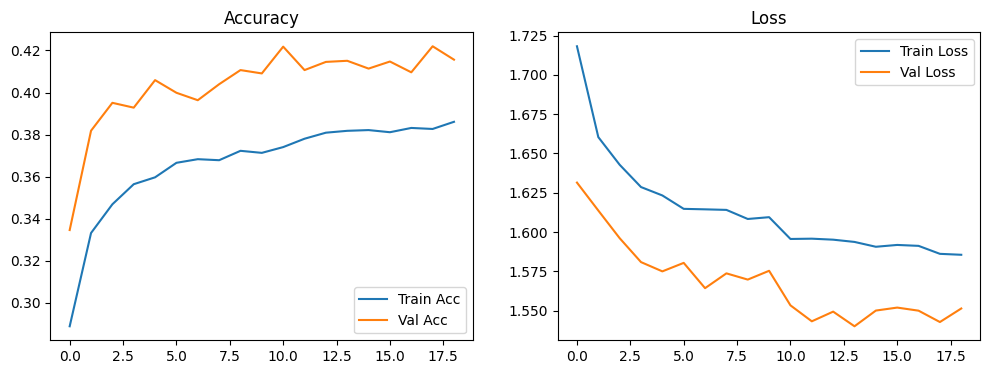

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


221/221 ━━━━━━━━━━━━━━━━━━━━ 90s 406ms/step - accuracy: 0.2907 - loss: 1.6327
Test Accuracy: 0.43
221/221 ━━━━━━━━━━━━━━━━━━━━ 83s 374ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.43      0.12      0.19       958
        fear       0.25      0.04      0.06      1024
       happy       0.47      0.78      0.58      1774
     neutral       0.40      0.31      0.34      1233
         sad       0.35      0.49      0.41      1247
    surprise       0.51      0.60      0.55       831

    accuracy                           0.43      7067
   macro avg       0.40      0.39      0.36      7067
weighted avg       0.40      0.43      0.38      7067



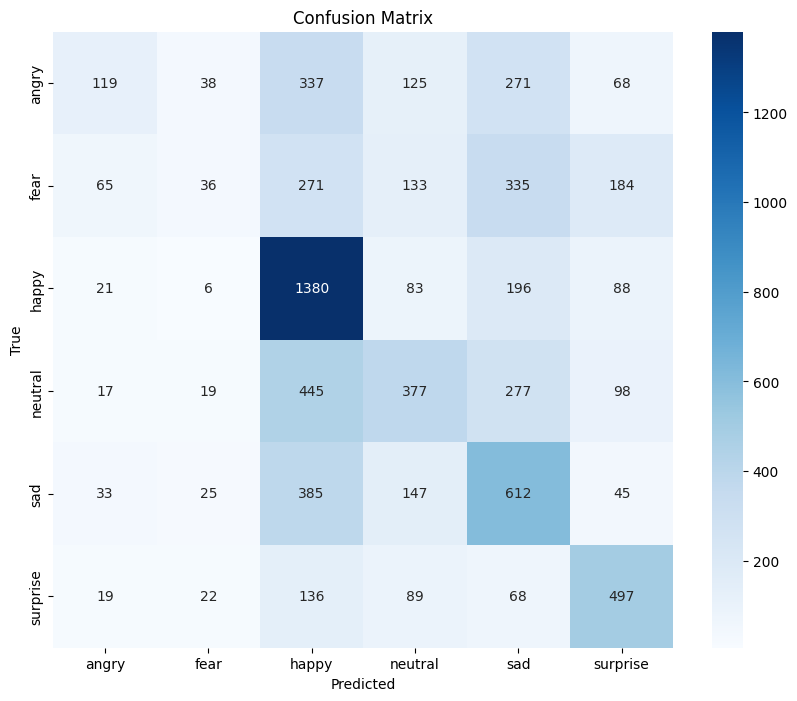

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
